Notebook to:
* Read Embedded Element Patterns for AA0.5 stations.
* Generate observed and model AA0.5 visibilities.
    * Observed visibilities being the model with random calibration errors and noise
    * Separately for a solar model and a galactic model
* Run calibration
* Display the results.

It requires local copies of the EEP files. These should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
# Imports

import logging
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np

from astropy import constants as const
from astropy import units
from astropy.coordinates import AltAz, SkyCoord, get_sun
from astropy.time import Time

from ska_low_mccs_calibration.calibration import calibrate_mccs_visibility
from ska_low_mccs_calibration.eep import (
    load_eeps,
    resample_eeps,
    station_rotation_matrix,
)

from ska_low_mccs_calibration.sky_model import (
    gsmap_lsm,
    gsmodel,
    predict_vis,
    solar_lsm,
)
from ska_low_mccs_calibration.sky_model import (
    solar_lsm,
)
from ska_low_mccs_calibration.utils import (
    read_yaml_config,
    sdp_visibility_datamodel,
)

log = logging.getLogger()
log.addHandler(logging.StreamHandler(sys.stdout))
log.setLevel(logging.WARN)

warnings.filterwarnings("ignore")







<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
# Get station info 

stations = ["s8-1.yaml", "s8-6.yaml", "s9-2.yaml", "s10-3.yaml"]

nantenna = 256
nbaselines = nantenna * (nantenna + 1) // 2

nstation = len(stations)
location = [""] * nstation
bl_ids = np.zeros((nstation, 2, nbaselines), "int")
enu = np.zeros((nstation, 3, nantenna), "float")
rotation = np.zeros(nstation, "float")
uvw_m = np.zeros((nstation, nbaselines, 3), "float")

for stn_id, station in enumerate(stations):
    config = read_yaml_config(station)
    assert len(config[1]) == nantenna
    # config = [station_location, antenna_masks, baseline_ids, enu, pol, rotation]
    location[stn_id] = config[0]
    bl_ids[stn_id] = config[2]
    enu[stn_id] = config[3]
    rotation[stn_id] = config[5]
    uvw_m[stn_id] = (enu[stn_id][:, bl_ids[stn_id, 0]] - enu[stn_id][:, bl_ids[stn_id, 1]]).T

In [3]:
# Generate zeroed xarrays for the station visibilities

# Observing frequency
channel_id = 140
channel_bw_MHz = 400.0 / 512.0
freq = channel_id * channel_bw_MHz
npol = 4

# Some time during the day at a longitude of ~ 8 hours
time_cal = Time("2024-01-05T03:00:00", format="isot", scale="utc")

mdl_sun = [""] * nstation
mdl_gal = [""] * nstation

for stn_id, station in enumerate(stations):
    mdl_vis = sdp_visibility_datamodel(
        vis=np.zeros((nbaselines, npol), "complex"),
        flags=np.zeros((nbaselines, npol), "bool"),
        uvw=uvw_m[stn_id],
        ant1=bl_ids[stn_id][0],
        ant2=bl_ids[stn_id][1],
        location=location[stn_id],
        antpos_enu=enu[stn_id].T,
        time=time_cal,
        int_time=1,
        frequency_mhz=freq,
    )
    mdl_sun[stn_id] = mdl_vis.copy(deep=True)
    mdl_gal[stn_id] = mdl_vis.copy(deep=True)

In [4]:
# Get rotated EEPs for the four AA0.5 stations

# Observing frequency
channel_id = 140
channel_bw_MHz = 400.0 / 512.0
freq = channel_id * channel_bw_MHz

eep_file_path = "./AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"
EEPs = load_eeps(freq, eep_file_path)

In [5]:
# Fill visibility xarrays

CVEL = const.c.value

# Generate local sky model for the sun
[az_sun, el_sun, T_sun] = solar_lsm(freq, location=location[0], time=time_cal)
assert el_sun > 0
az_sun = np.array([az_sun])
el_sun = np.array([el_sun])
T_sun = np.array([T_sun])
print(f"Solar model with 1 pixel at azimuth = {az_sun[0]:.1f} degrees, elevation = {el_sun[0]:.1f} degrees")

# Generate local sky model for the galaxy
# num pixels (hemisphere) = 12*nside^2 / 2 = 384 for nside=8
# resolution ~ sqrt(4*pi/(12*nside^2) sr) = 7.33 deg for nside=8
nside = 4
gsmap = gsmodel(freq, nside)[0]
[az_gsm, el_gsm, T_gsm] = gsmap_lsm(gsmap, location=location[0], time=time_cal)
print(f"Galactic model with {len(az_gsm)} pixels")

shape = mdl_gal[stn_id].vis.data.shape

for stn_id, _ in enumerate(stations):

    delays = uvw_m[stn_id].T * (1e9 / CVEL)

    mdl_sun[stn_id].vis.data = np.array(
        predict_vis(EEPs, rotation[stn_id], bl_ids[stn_id].T, delays, freq, az_sun, el_sun, T_sun)
    ).T.reshape(shape)

    # Generate a new set of EEPs that are normalised for the galactic sky model
    mdl_gal[stn_id].vis.data = np.array(
        predict_vis(EEPs, rotation[stn_id], bl_ids[stn_id].T, delays, freq, az_gsm, el_gsm, T_gsm, normalise_beam=True)
    ).T.reshape(shape)

Solar model with 1 pixel at azimuth = 81.0 degrees, elevation = 71.8 degrees
Galactic model with 96 pixels


In [6]:
# Add corruptions and noise to the observed visibilities
#  - Note that these corruptions are not set based on reality or meant to be representative.
#    - They are chosen to highlight differences in the calibration solutions.
#  - Also incorporate station rotation errors? Would need to redo the predict step...

def gen_xy_phase():
    # random xy-phase plus a constant one for the station (for a station-dependent non-zero mean)
    sigma_ant = 10 * np.pi / 180
    sigma_stn = 10 * np.pi / 180
    xy_phase = np.random.normal(0.0, sigma_ant, nantenna) + np.random.normal(0.0, sigma_stn)
    phasor = np.zeros((nantenna, 2, 2), "complex")
    phasor[:, 0, 0] = 1.0
    phasor[:, 1, 1] = np.exp(1j * xy_phase)
    return phasor

def gen_gain():
    # random gains plus a constant factor for the station
    # don't make them too big, or they will be flagged!
    sigma_ant = 0.03
    sigma_stn = 0.03
    gain = np.zeros((nantenna, 2, 2), "complex")
    gain[:, 0, 0] = np.random.normal(1.0, sigma_stn) + 1j * np.random.normal(0.0, sigma_stn)
    gain[:, 1, 1] = np.random.normal(1.0, sigma_stn) + 1j * np.random.normal(0.0, sigma_stn)
    gain[:, 0, 0] += np.random.normal(0.0, sigma_ant, nantenna) + 1j * np.random.normal(0.0, sigma_ant, nantenna)
    gain[:, 1, 1] += np.random.normal(0.0, sigma_ant, nantenna) + 1j * np.random.normal(0.0, sigma_ant, nantenna)
    return gain

def gen_leakage():
    # random leakage plus a constant one for the station (similar to a station rotation)
    #  - just make dxy = -dyx?
    sigma_ant = 0.1
    sigma_stn = 0.03
    leakage = np.ones((nantenna, 2, 2), "complex")
    leakage_stn = np.random.normal(0.0, sigma_stn)
    leakage[:, 0, 1] = +leakage_stn
    leakage[:, 1, 0] = -leakage_stn
    leakage[:, 0, 1] = np.random.normal(0.0, sigma_ant, nantenna) + 1j * np.random.normal(0.0, sigma_ant, nantenna)
    leakage[:, 1, 0] = np.random.normal(0.0, sigma_ant, nantenna) + 1j * np.random.normal(0.0, sigma_ant, nantenna)
    return leakage

jones = [""] * nstation
vis_sun = [""] * nstation
vis_gal = [""] * nstation

for stn_id, _ in enumerate(stations):

    # generate Jones matrices and save a copy for comparisons later
    jones[stn_id] = np.einsum("axp,apq,aqy->axy", gen_leakage(), gen_gain(), gen_xy_phase())

    # generate observed visibilities using the models and calibration corruptions
    vis_gal[stn_id] = mdl_gal[stn_id].copy(deep=True)
    stn1 = mdl_gal[stn_id].baselines.antenna1
    stn2 = mdl_gal[stn_id].baselines.antenna2
    vis_gal[stn_id].vis.data = np.einsum(
        "bxp,tbfpq,byq->tbfxy",
        jones[stn_id][stn1],
        mdl_gal[stn_id].vis.data.reshape(1, nbaselines, 1, 2, 2),
        jones[stn_id][stn2].conj(),
    ).reshape(1, nbaselines, 1, 4)

    vis_sun[stn_id] = mdl_sun[stn_id].copy(deep=True)
    stn1 = mdl_sun[stn_id].baselines.antenna1
    stn2 = mdl_sun[stn_id].baselines.antenna2
    vis_sun[stn_id].vis.data = np.einsum(
        "bxp,tbfpq,byq->tbfxy",
        jones[stn_id][stn1],
        mdl_sun[stn_id].vis.data.reshape(1, nbaselines, 1, 2, 2),
        jones[stn_id][stn2].conj(),
    ).reshape(1, nbaselines, 1, 4)

    # add noise?
    sigma = 0.0
    shape = mdl_gal[stn_id].vis.data.shape
    noise = sigma * (np.random.normal(0.0, sigma, shape) + 1j * np.random.normal(0.0, sigma, shape))
    vis_gal[stn_id].vis.data += noise
    vis_sun[stn_id].vis.data += noise

In [7]:
# Show some extra output
log.setLevel(logging.DEBUG)
handler = log.handlers[0]
handler.setLevel(logging.DEBUG)

# whether or not to refit with a polarised solver
jones_solve = True

gain_sun = [""] * nstation
gain_gal = [""] * nstation

for stn_id, _ in enumerate(stations):
    gain_sun[stn_id], _, _, _, info = calibrate_mccs_visibility(
        vis_sun[stn_id],
        skymodel=mdl_sun[stn_id],
        masked_antennas=np.array([]),
        jones_solve=jones_solve,
    )
    gain_gal[stn_id], _, _, _, info = calibrate_mccs_visibility(
        vis_gal[stn_id],
        skymodel=mdl_gal[stn_id],
        masked_antennas=np.array([]),
        jones_solve=jones_solve,
    )

# Or call solver directly
# from ska_sdp_func_python.calibration.solvers import solve_gaintable
# solver="normal_equations"
# for stn_id, _ in enumerate(stations):
#     gain_sun[stn_id] = solve_gaintable(vis=vis_sun[stn_id], modelvis=mdl_sun[stn_id], solver=solver, niter=200, tol=1e-06,  normalise_gains=None,  jones_type='G')
#     gain_gal[stn_id] = solve_gaintable(vis=vis_gal[stn_id], modelvis=mdl_gal[stn_id], solver=solver, niter=200, tol=1e-06,  normalise_gains=None,  jones_type='G')


# Show less output
handler = log.handlers[0]
handler.setLevel(logging.INFO)

Solving for input sky model
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Solving for complex gain
solve_gaintable: Creating new gaintable
solve_gaintable: Finished calibration
Additional Antennas rejected based on low gains: []
solve_gaintable: Starting calibration
solve_gaintable: Using solver normal_equations
solve_gaintable: Solving for complex gain
solve_gaintable: Starting from existing gaintable
solve_with_alternative_algorithm: solving for 1 chan in 1 sub-band[s] using solver normal_equations
solve_with_alternative_algorithm: sub-band 0, processing 1 channels:
_normal_equation_solve: iter 000 change: 6.3e-02
_normal_equation_solve: iter 001 change: 4.1e-03
_normal_equation_solve: iter 002 change: 3.1e-06
_normal_equation_solve: iter 003 change: 1.6e-11
_normal_equation_solve: gain solutions converged in 4 iterations for channel 0
solve_gaintable: Finished calibration
Solving: 11.19 seconds
Estimated XY-phase: -0.00 deg (i

### Generate expected beam response and cross-station visibilities to check calibration solutions

In [8]:
# Generate visibilities while tracking the sun at a range of hour angles

# Reference the time to the calibration point
hr_offsets = np.arange(-3, 6, 0.25)

# Generate empty arrays for storing various cross correlations
Ntype = 2 # types of corrections to consider
Nprod = nstation * (nstation - 1) // 2 # number of cross products
Nsnap = len(hr_offsets) # number of snapshots to consider
label = [""] * Ntype
auto_prod = np.zeros((nstation, Ntype, 2, 2, Nsnap), "complex")
cross_prod = np.zeros((Nprod, Ntype, 2, 2, Nsnap), "complex")
ha_sun = np.zeros(len(hr_offsets))

# There is no inter-station calibration.
#  - Need to at least do phase referencing.
#  - Should be constant so set on the first loop and store
phaseref = np.zeros([Ntype, nstation], "complex")

for hr_id, hr in enumerate(hr_offsets):
    time = time_cal + hr * units.hour

    skypos = get_sun(time)
    skypos_altaz = skypos.transform_to(AltAz(obstime=time, location=location[0]))
    az_deg = skypos_altaz.az.degree
    el_deg = skypos_altaz.alt.degree
    lst_deg = time.sidereal_time("mean", location[0].lon).degree
    ha_sun[hr_id] = lst_deg - skypos.ra.degree

    # Generate the expected observed beam response
    Jobs = np.zeros((nstation, nantenna, 2, 2), "complex")
    # And save the EEP matrices in the beam direction
    Jeep = np.zeros((nstation, nantenna, 2, 2), "complex")
    sigma = 0.0
    for stn_id, station in enumerate(stations):
        Jeep[stn_id] = np.array(
            resample_eeps(EEPs, rotation[stn_id], az_deg, el_deg)
        ).T.reshape(nantenna, 2, 2)

        shape = Jeep[stn_id].shape
        noise = sigma * (
            np.random.normal(0.0, sigma, shape) + 1j * np.random.normal(0.0, sigma, shape)
        )

        # multiply EEPs with the true calibration factors
        Jobs[stn_id] = np.einsum("axp,apy->axy", jones[stn_id], Jeep[stn_id]) + noise

    # Form expected response and cross products at beam centre
    #  - Assuming geometric phase factors have been corrected

    # ------------------------------------------------------------ #
    # Sun-based calibration and EEPs correction during beamforming #
    bftype = 0
    label[bftype] = "Solar cal at t=0"
    # Form the expected beam response for each station
    beam = np.zeros((nstation, 2, 2), "complex")
    for stn_id, station in enumerate(stations):
        # Multiply calibration matrices and EEPs
        Jcal = np.einsum("axp,apy->axy", gain_sun[stn_id].gain[0,:,0].data, Jeep[stn_id])
        # Weighted average over antennas
        beam[stn_id] = (
            np.linalg.inv(np.einsum("apx,apy->xy", Jcal.conj(), Jcal))
            @ np.einsum("apx,apy->xy", Jcal.conj(), Jobs[stn_id])
        )
        # Could alternatively mult by inv(Jcal) and average
        # Jcal = np.zeros((nantenna, 2, 2), "complex")
        # for ant_id in range(nantenna):
        #     Jcal[ant_id] = np.linalg.inv(gain_sun[stn_id].gain[0,ant_id,0].data @ Jeep[stn_id, ant_id])
        # # Average over antennas
        # beam[stn_id] = np.einsum("axp,apy->xy", Jcal, Jobs[stn_id]) / nantenna
        if hr_id == 0:
            phaseref[bftype, stn_id] = np.exp(-1j * np.angle(beam[stn_id][0, 0]))
        beam[stn_id] *= phaseref[bftype, stn_id]
    # Form expected cross products for each pair of stations
    for stn_id, station in enumerate(stations):
        auto_prod[stn_id, bftype, :, :, hr_id] = beam[stn_id] @ beam[stn_id].conj().T
    prod_id = 0
    for stn1 in range(nstation - 1):
        for stn2 in range(stn1 + 1, nstation):
            cross_prod[prod_id, bftype, :, :, hr_id] = beam[stn1] @ beam[stn2].conj().T
            prod_id += 1

    # ------------------------------------------------------------ #
    # GSM-based calibration and EEPs correction during beamforming #
    bftype = 1
    label[bftype] = "Galactic cal at t=0"
    # Form the expected beam response for each station
    beam = np.zeros((nstation, 2, 2), "complex")
    for stn_id, station in enumerate(stations):
        # Multiply calibration matrices and EEPs
        Jcal = np.einsum("axp,apy->axy", gain_gal[stn_id].gain[0,:,0].data, Jeep[stn_id])
        # Weighted average over antennas
        beam[stn_id] = (
            np.linalg.inv(np.einsum("apx,apy->xy", Jcal.conj(), Jcal))
            @ np.einsum("apx,apy->xy", Jcal.conj(), Jobs[stn_id])
        )
        # Could alternatively mult by inv(Jcal) and average
        # Jcal = np.zeros((nantenna, 2, 2), "complex")
        # for ant_id in range(nantenna):
        #     Jcal[ant_id] = np.linalg.inv(gain_gal[stn_id].gain[0,ant_id,0].data @ Jeep[stn_id, ant_id])
        # # Average over antennas
        # beam[stn_id] = np.einsum("axp,apy->xy", Jcal, Jobs[stn_id]) / nantenna
        if hr_id == 0:
            phaseref[bftype, stn_id] = np.exp(-1j * np.angle(beam[stn_id][0, 0]))
        beam[stn_id] *= phaseref[bftype, stn_id]
    # Form expected cross products for each pair of stations
    for stn_id, station in enumerate(stations):
        auto_prod[stn_id, bftype, :, :, hr_id] = beam[stn_id] @ beam[stn_id].conj().T
    prod_id = 0
    for stn1 in range(nstation - 1):
        for stn2 in range(stn1 + 1, nstation):
            cross_prod[prod_id, bftype, :, :, hr_id] = beam[stn1] @ beam[stn2].conj().T
            prod_id += 1

### Station auto-correlations

Polarised calibration on an unpolarised source like the sun cannot constrain all of the unknowns. In general each Jones matrix in a given set of solutions will be multiplied by a unitary matrix. This unitary matrix will also be present in the formed beam, and so will cancel in auto-correlations. This can be seen at the point of calibration in the plots below.

The wide-field galactic sky model is also unpolarised, but contains significant instrumental polarisation that varies with direction and baseline. This better constrains the full polarised problem.

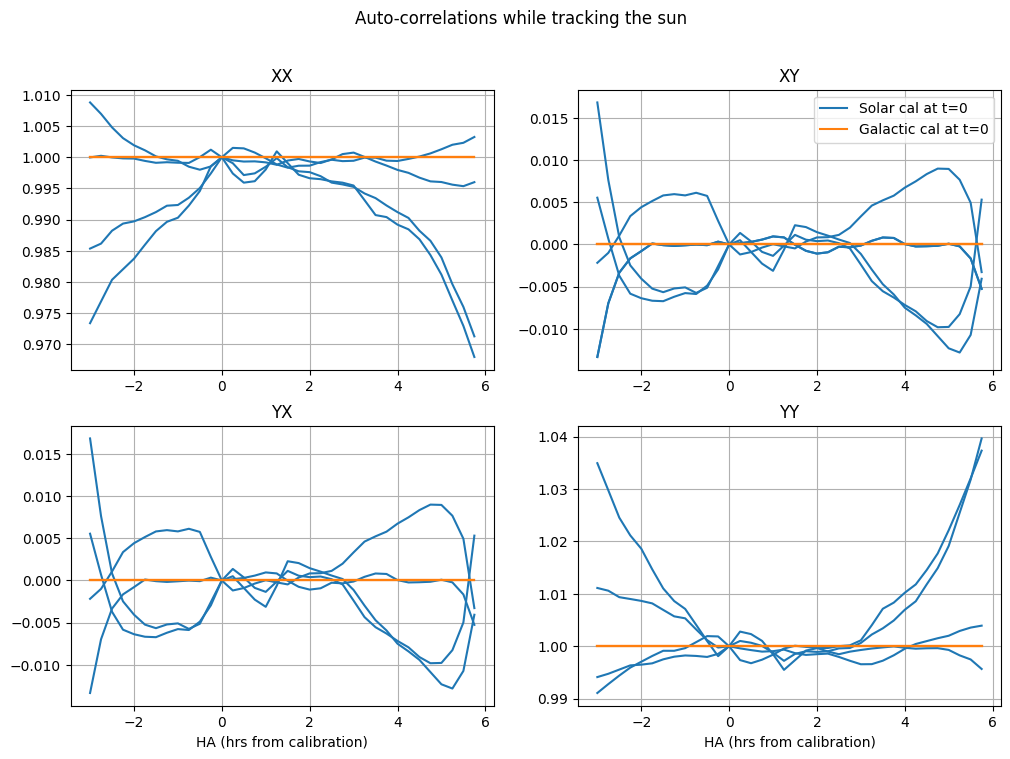

In [9]:
types_to_plot = range(Ntype)

fig = plt.figure(figsize=[12,8])
fig.suptitle("Auto-correlations while tracking the sun")
plt.subplot(221)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(auto_prod[:, bftype, 0, 0]).T, f"C{bftype}")
plt.title("XX")
plt.grid()
plt.subplot(222)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(auto_prod[0, bftype, 0, 1]).T, f"C{bftype}", label=label[bftype])
    plt.plot(hr_offsets, np.real(auto_prod[:, bftype, 0, 1]).T, f"C{bftype}")
plt.title("XY")
plt.grid()
plt.legend()
plt.subplot(223)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(auto_prod[:, bftype, 1, 0]).T, f"C{bftype}")
plt.title("YX")
plt.xlabel("HA (hrs from calibration)")
plt.grid()
plt.subplot(224)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(auto_prod[:, bftype, 1, 1]).T, f"C{bftype}")
plt.title("YY")
plt.xlabel("HA (hrs from calibration)")
plt.grid()

### Station cross-correlations

In cross-correlations the beams contain different unitary matrices due to the calibrtion process. This difference can be seen in the plots below.

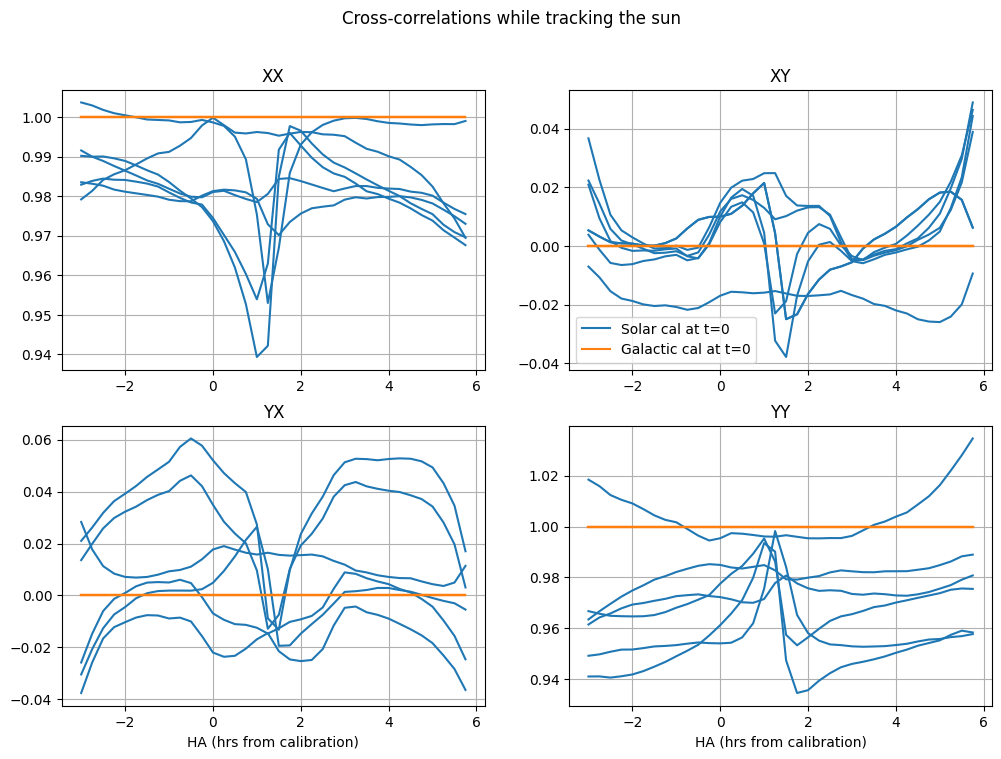

In [10]:
types_to_plot = range(Ntype)

fig = plt.figure(figsize=[12,8])
fig.suptitle("Cross-correlations while tracking the sun")
plt.subplot(221)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(cross_prod[:, bftype, 0, 0]).T, f"C{bftype}")
plt.title("XX")
plt.grid()
plt.subplot(222)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(cross_prod[0, bftype, 0, 1]).T, f"C{bftype}", label=label[bftype])
    plt.plot(hr_offsets, np.real(cross_prod[:, bftype, 0, 1]).T, f"C{bftype}")
plt.title("XY")
plt.grid()
plt.legend()
plt.subplot(223)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(cross_prod[:, bftype, 1, 0]).T, f"C{bftype}")
plt.title("YX")
plt.xlabel("HA (hrs from calibration)")
plt.grid()
plt.subplot(224)
for bftype in types_to_plot:
    plt.plot(hr_offsets, np.real(cross_prod[:, bftype, 1, 1]).T, f"C{bftype}")
plt.title("YY")
plt.xlabel("HA (hrs from calibration)")
plt.grid()